# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

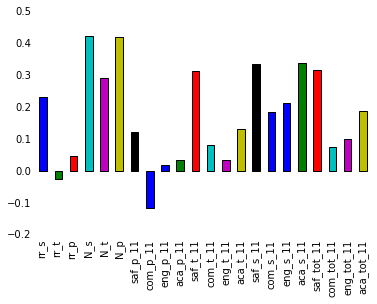

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Ploting the correlation between sat_score and the variables from the survey_fields:
sat_survey_corr = combined.corr()['sat_score'][survey_fields].plot.bar()

# Removing all the ticks from both the x and the y axis of our 
# sat_survey_corr graph:
sat_survey_corr.tick_params(bottom='off', top='off', 
                           left='off', right='off')
# Removing all the four spines from our graph:
for key, spine in sat_survey_corr.spines.items():
    spine.set_visible(False)


#### We can see strong correlations between *sat_score* and *N_s* (Number of students respondents); *N_p* (Number of parent respondents) with a positive correlation of more than 0.4. Followed by *aca_s_11* (Academic expectations score based on student responses); *saf_s_11* (Safety and Respect score based on student responses), and *saf_t_11* (Safety and Respect score based on teacher responses) with a positive correlation of more than 0.3.
#### The students/teachers that scored high in these parameters from these surveys also got high scores in their SAT exams.

# Digging deeper into the safety scores 

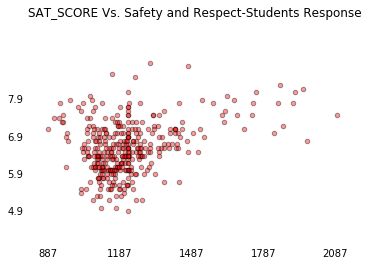

In [11]:
fig, ax = plt.subplots()
ax.scatter(combined['sat_score'], combined['saf_s_11'], c='red', alpha=.4)

ax.tick_params(bottom='off', top='off', left='off', right='off')

for key, spine in ax.spines.items():
    spine.set_visible(False)
    
ax.set_title('SAT_SCORE Vs. Safety and Respect-Students Response')
ax.set_xticks(np.arange(combined['sat_score'].min(), combined['sat_score'].max(),
                       300))
ax.set_yticks(np.arange(combined['saf_s_11'].min(), combined['saf_s_11'].max()))

plt.show()

#### The evidences are clear: lower *Safety and Respect score based on student responses* are almost always followed by lower *sat_scores*. As we can perceive from our left populated skewed scatter plot. 

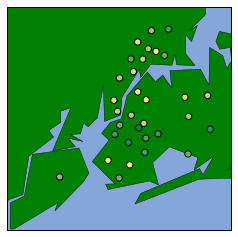

In [12]:
from mpl_toolkits.basemap import Basemap

safety_pivot = combined.pivot_table(values=['saf_s_11', 'lon', 'lat'],
                            index='school_dist', aggfunc='mean', 
                                   )

# safety_avg = combined.groupby('school_dist')['saf_s_11'].mean()

# safety_avg.head() 


# Passing into a list both the Series lat as lon, from our Dataset combined,
# in order to use them and pass them as arguments in our scatter plot of our
# NYC map. Both these Series contain all of the geografic points related to
# the the location of our schools in the NYC map:
lat = safety_pivot['lat'].tolist()
lon = safety_pivot['lon'].tolist()

# Constructing our NYC map, resorting to the Basemap module:
m = Basemap(resolution= 'i',
            projection='merc',
            llcrnrlat=40.496044,
            urcrnrlat=40.915256,
            llcrnrlon=-74.255735,
            urcrnrlon=-73.700272,
            )
m.drawrivers(linewidth=.5, color='k')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(linewidth=.4, color='k')
m.fillcontinents(color='g')

# Drawing a scatter plot of the map of the NYC with the safety_avg levels 
# per district:
m.scatter(lon,
          lat,
          s=40,
          c=safety_pivot['saf_s_11'],
          cmap= 'summer',
          zorder=4,
          latlon=True)

plt.show()


#### The majority of the *safest* schools, acording to students perception, tend to be located around the Manhattan, Queens, and south Brooklyn areas. 
#### On the other hand, most of the *dangerous* schools, are mainly located in the Staten Island, Bronx and upper Brooklyn Boroughs.
#### It would be interesting to cross this information with other demographics, such as race or crime rate, for example. Or with average income per Borough.

# Correlating Sat_Scores with Demographics associated to Race

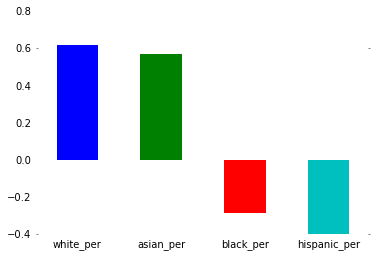

In [13]:
# Ploting a Bar graph on the relation between the sat_scores and the percentage
# of students by their race in their respective schools:
race_sat_corr = combined.corr()['sat_score'][['white_per', 'asian_per', 
                'black_per', 'hispanic_per']].plot.bar(edgecolor='none')

race_sat_corr.tick_params(bottom='off', top='off', left='off', right='off')
race_sat_corr.set_yticks(np.arange(combined.corr()['sat_score'][['white_per', 'asian_per', 
                'black_per', 'hispanic_per']].min(), combined.corr()['sat_score'][['white_per', 'asian_per', 
                'black_per', 'hispanic_per']].max()), .5)
plt.xticks(rotation='horizontal')

for key, spine in race_sat_corr.spines.items():
    spine.set_visible(False)


#### From the graphic bar above we can clearly identify two patterns: 
    - The white_per and the asian_perc of students both score a high positive level of correlation with the sat_scores (above .5);
    - Both the black_perc and the hispanic_perc of students have meaningful levels of negative correlation with the sat_scores (-.2 and -.4, respectively).

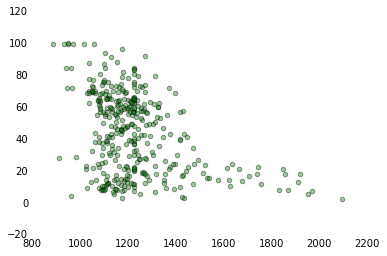

In [14]:
# Exploring the schools with low sat_scores and high percentage of 
# hispanic students:
fig, ax = plt.subplots()

ax.scatter(combined['sat_score'], combined['hispanic_per'], c='g', alpha=.4)

ax.tick_params(bottom='off', top='off', left='off', right='off')

for key, spine in ax.spines.items():
    spine.set_visible(False)

#### Schools with high percentage (above 50%) of hispanic students present, generally, lower sat scores (bellow 1200).

In [15]:
# Schools populated with more than 95% hispanic students:
hispanic_high = combined[combined['hispanic_per']>95]
hispanic_high.head(10)



,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


#### The schools all have some hispanic heritage or are hispanic students orientated. Offering a smoth transition to students from spanish speaking to english and to newly arrived hispanic immigrants. We also see some hispanic International Schools.

In [16]:
# Schools with less than 10% hispanic students and with an average 
# sat score greater than 1800:
hispanic_low_sat_score_high = combined[(combined['sat_score'] > 1800)
                                      & (combined['hispanic_per'] < 10)
                                      ]

hispanic_low_sat_score_high.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0,0,0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0,0,0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


#### These group of schools that score the best in the SAT tests, and where hispanic students present themselves as a minority, are all schools in the category of High School, highly Specialized, and Elitist. Where to get in and to be accepted a student has first to pass a round of tests/interviews.

# Correlating Sat_Scores with Demographics associated to Gender

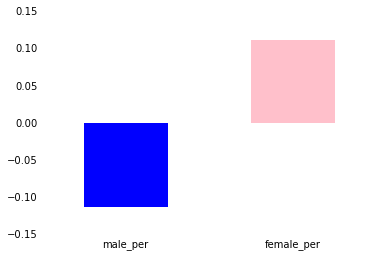

In [17]:
# Plotting a bar graph of the correlations between male_per, female_per, 
# and sat_score:
gender_sat_corr = combined.corr()[
    'sat_score'][[
    'male_per', 'female_per']].plot.bar(color=['blue', 'pink'],
                                       edgecolor='none')
plt.xticks(rotation=360)

gender_sat_corr.tick_params(bottom='off', top='off', left='off', right='off')

for key, spine in gender_sat_corr.spines.items():
    spine.set_visible(False)

#### We see both positive and negative non-material correlations between the two genders and sat_scores. 
#### On one side the male gender presents a slightly negative correlation with the sat_score, around -0.11. The correlation between female gender and sat_score is positively tenuous,  around 0.11.

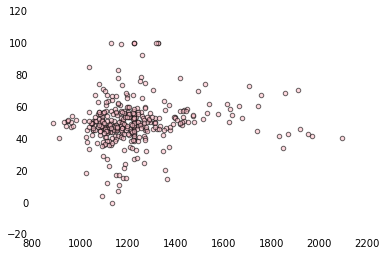

In [18]:
# Exploring the schools with high sat_scores and high percentage of 
# female students:
fig,ax = plt.subplots()

ax.scatter(
    combined['sat_score'], combined['female_per'],
    c='pink', alpha=.6)

ax.tick_params(bottom='off', top='off', left='off', right='off')

for key, spine in ax.spines.items():
    spine.set_visible(False)
    
plt.show()

#### There is no clear positive or negative correlations, as it would be expected, but one can conclude something: the majority of the schools where the percentage of female students is between 40%-60% score an average sat of around 1200.

In [19]:
# Schools with more than 60% female students and with an average 
# sat score greater than 1700:
female_high_sat_score_high = combined[
    (combined['sat_score']>1700)
    &
    (combined['female_per']>60)]

female_high_sat_score_high.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


#### All these schools have somethings in common:
    - very sought-after schools;
    - very hard and meticulous admissions;
    - an unorthodox approach to learning, and to all the learning standards;
    - some of them are more leaned to the study of arts and drama;
    - all of them have a wide variety of offers in the extracurricular activities;
    - well prepared teachers with top training;
    - strong college admission orientated. 


# Relating the percentage of students who took the Advanced Placement (AP) exams with the average SAT scores

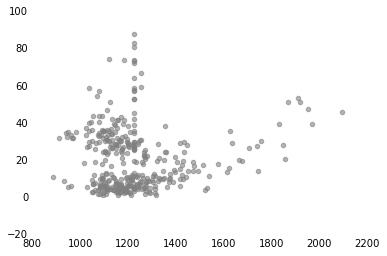

In [28]:
# Because the total_enrollment is highly correlated with the school's SAT scores
# let's instead try to use the percentage of students, from all the ones that
# enrolled, who took at least one AP exame, in order to do an unbiased analysis:
combined['AP_per'] = (combined['AP Test Takers ']/combined['total_enrollment'])*100
combined['AP_per'].head()

# Plotting the relationship between the Advanced Placemente Percentage (AP_per)
# and the average SAT scores:
fig, ax = plt.subplots()

ax.scatter(combined['sat_score'],
        combined['AP_per'], 
        color='grey', alpha=.6)

ax.tick_params(bottom='off',
             top='off',
             left='off',
             right='off')

for key,spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

#### There is no clear correlation between the two variables. The funny thing is that we have observations in both specters: a high percentage of students, although in a smaller occurrence,  who undertook the AP exams, above 60%, that scored an average of around 1200 in the sat, and a low percentage of students who undertook the AP exams, bellow 40%, that scored practically the same in the sat. 

#### We cannot afirm, with any degree of confidence, that the higher the percentage of students who took the AP exams, the better they scored in the SAT. The data simply does not corroborate that statement.  